<a href="https://colab.research.google.com/github/ailuj/BayesianDeepLearning/blob/playground/BNN_Binary_pymc3_theano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
1from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [0]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(theano.config.floatX)
Y = Y.astype(theano.config.floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)


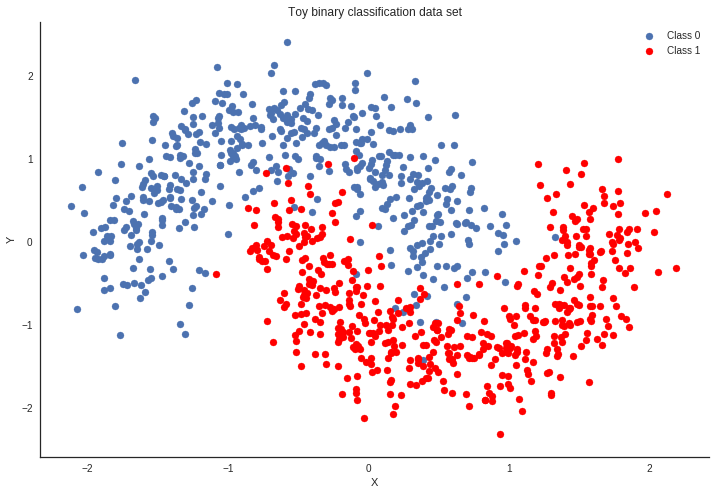

In [0]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [0]:

def construct_nn(ann_input, ann_output):

  n_hidden = 5
    
    # Initialize random weights between each layer
  init_1 = np.random.randn(X.shape[1], n_hidden).astype(theano.config.floatX)
  init_2 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
  init_out = np.random.randn(n_hidden).astype(theano.config.floatX)
  
  with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
        return neural_network

  
# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

# Usually we would add a constant b to the inputs but I omitted it here to keep the code cleaner.

In [0]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

Inference

In [0]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

Average Loss = 126.9: 100%|██████████| 50000/50000 [01:19<00:00, 631.95it/s]
Finished [100%]: Average Loss = 127


CPU times: user 1min 3s, sys: 9.05 s, total: 1min 12s
Wall time: 2min 2s


Sampling from VI

In [0]:
trace = approx.sample(draws=5000)


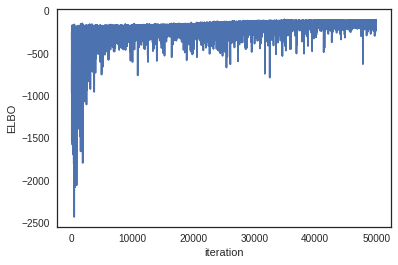

In [0]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

Prediction

In [0]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

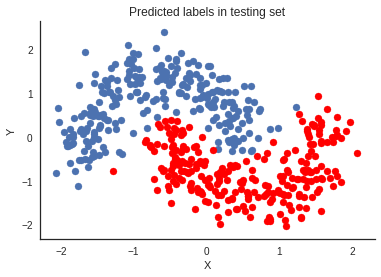

In [0]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [0]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))


Accuracy = 95.39999999999999%


So far, we could have done it with a non-Bayesian NN. The mean of the posterior predictive for each label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions.

**Let's look at what the classifier has learned**

In [0]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [0]:
## Evaluate the class probability predictions on a grid over the whole input space

ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

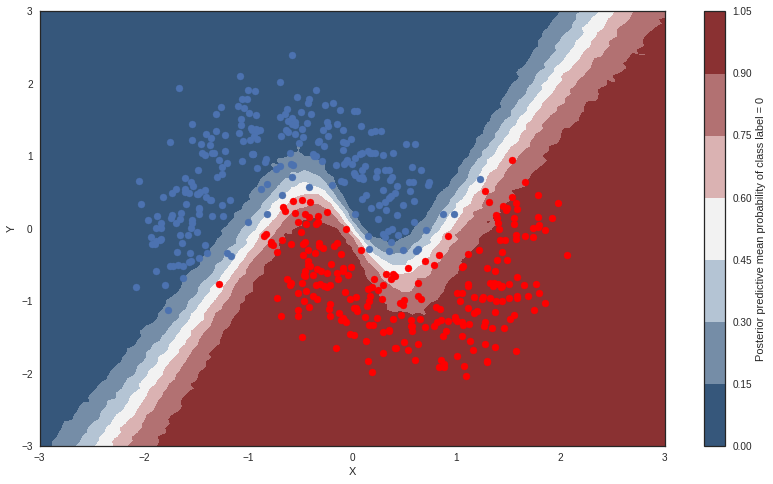

In [0]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

Look at the standard deviation of the posterior

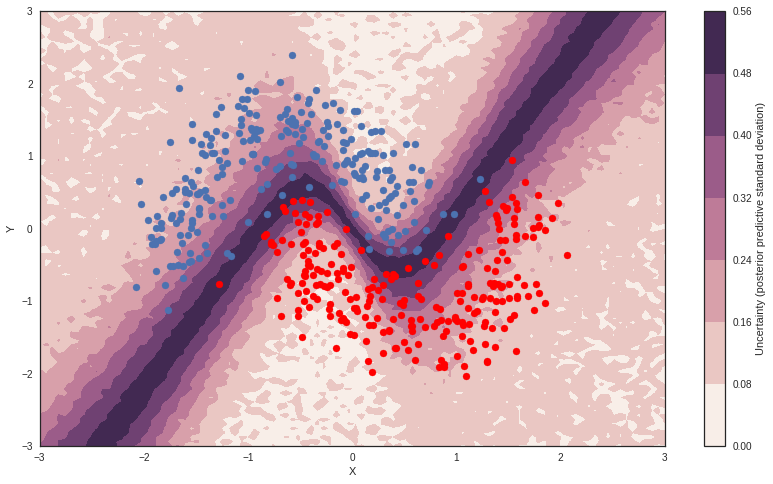

In [0]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [0]:
minibatch_x = pm.Minibatch(X_train, batch_size=32)
minibatch_y = pm.Minibatch(Y_train, batch_size=32)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(40000, method=inference)

Average Loss = 8.9856: 100%|██████████| 40000/40000 [00:44<00:00, 904.78it/s]
Finished [100%]: Average Loss = 8.9642


plot elbo

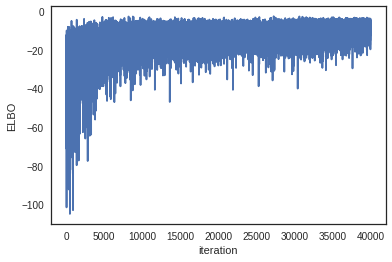

In [0]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

Plotting the uncertainty we get on our weights

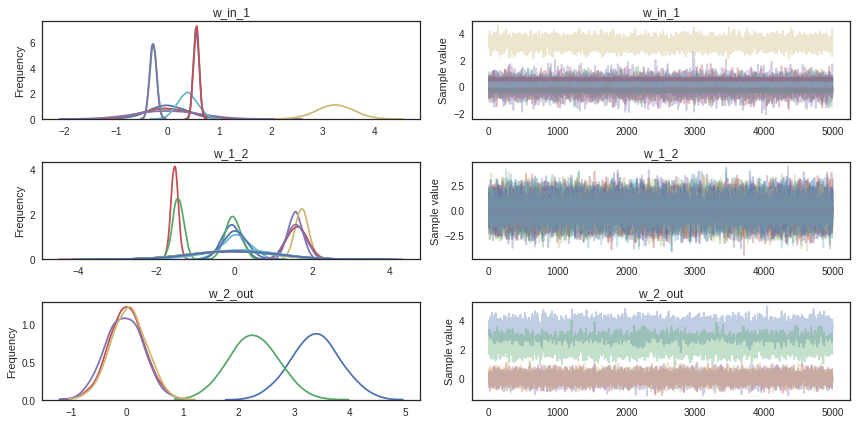

In [0]:
pm.traceplot(trace);


**HAMILTONIAN MONTE CARLO**

After constructing the model, we may also choose to sample from the posterior by HMC

In [0]:
with neural_network:
    step = pm.step_methods.HamiltonianMC(vars=neural_network.vars)
    trace_HMC = pm.sample(2000, step)

Sequential sampling (2 chains in 1 job)
HamiltonianMC: [w_2_out, w_1_2, w_in_1]
100%|██████████| 2500/2500 [00:42<00:00, 58.37it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [0]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace_HMC, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

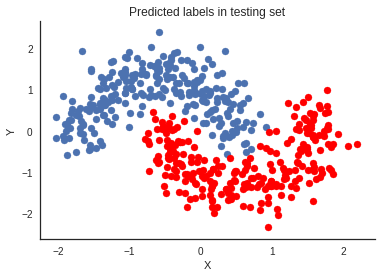

In [0]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [0]:
print('Accuracy_HMC = {}%'.format((Y_test == pred).mean() * 100))


Accuracy_HMC = 95.0%


In [0]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [0]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace_HMC, samples=500, progressbar=False)

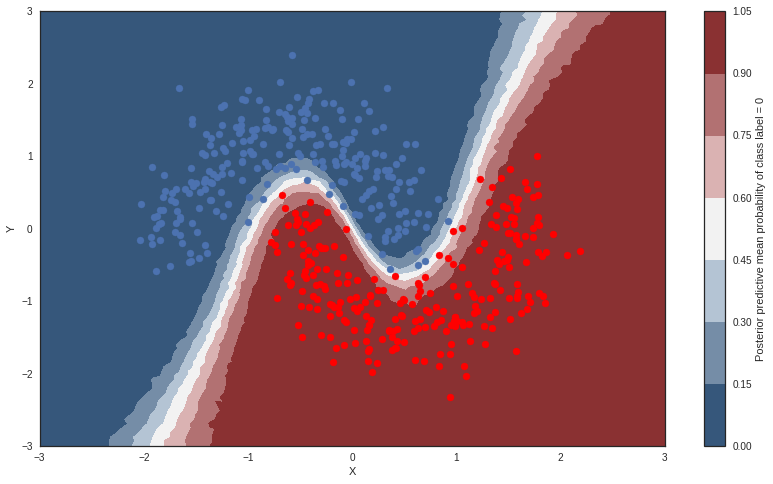

In [0]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

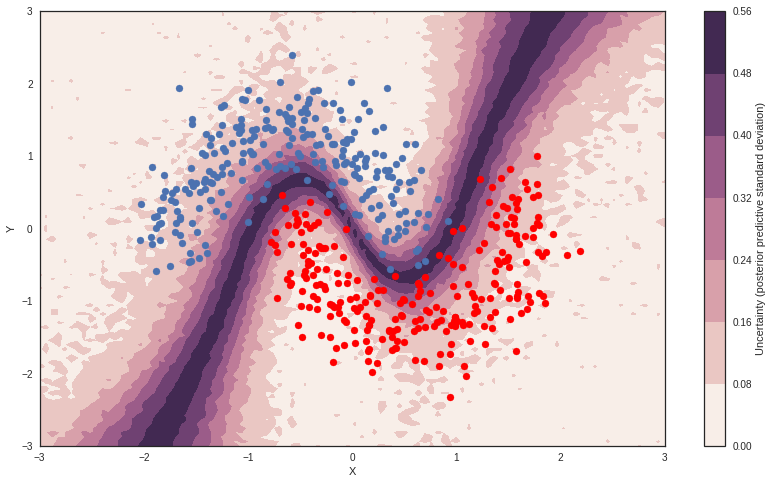

In [0]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

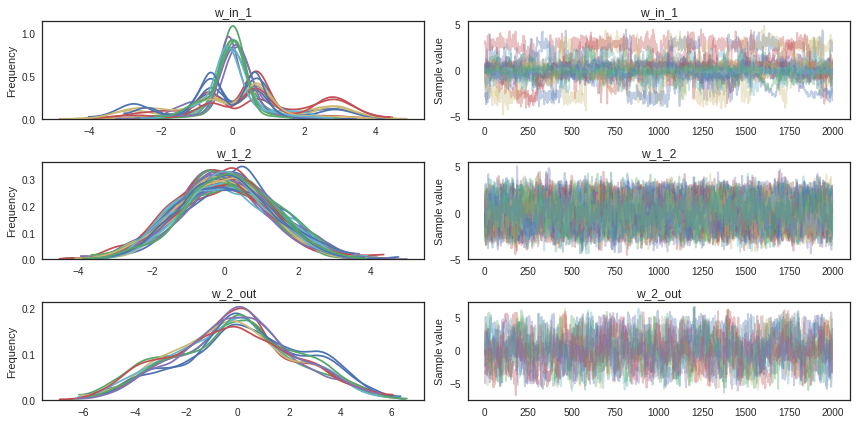

In [0]:
pm.traceplot(trace_HMC)